# Reddit /r/relationships Title Prediction
## Setup
I start by using a preprocessed [pickle file](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_pickle.html). I would happily use feather, but they [dont have datetimes figured out yet](https://github.com/wesm/feather/issues/121). I added the time featured I wanted, so this notebook could focus on prediction.

In [1]:
%matplotlib inline

import pandas as pd
from pathlib import Path
import sqlite3
from matplotlib import pyplot as plt
import re
import numpy as np
import math
from random import random, sample, seed
import sys

project_dir = Path.cwd().parent
dataframe_path = project_dir/'data'/'processed'/'added_time_features.pickle'
embeddings_path = project_dir/'data'/'external'/'glove.twitter.27B.200d.txt'

sys.path.append(str(project_dir/'src'))
from features import utilities

plt.style.use('ggplot')

df = pd.read_pickle(dataframe_path)

In [2]:
df.head()

,id,author,downs,edited,edited_date,locked,name,num_comments,permalink,score,...,month,dayofyear,dayofweek,hour,minute,second,edited_delta,edited_delta_min,edited_delta_hour,edited_delta_day
created,,,,,,,,,,,,,,,,,,,,,
2009-04-27 23:48:55,8fs8j,mydearlove,0,0,2009-04-27 23:48:55,1,t3_8fs8j,1,/r/relationships/comments/8fs8j/love_poems/,1,...,4,117,0,23,48,55,0 days,0.0,0.0,0
2009-07-05 04:12:37,8y7am,Ashley89,0,0,2009-07-05 04:12:37,1,t3_8y7am,0,/r/relationships/comments/8y7am/when_shes_gone/,2,...,7,186,6,4,12,37,0 days,0.0,0.0,0
2009-07-14 03:09:45,90r8g,mrggfep,0,0,2009-07-14 03:09:45,1,t3_90r8g,0,/r/relationships/comments/90r8g/men_have_it_ro...,2,...,7,195,1,3,9,45,0 days,0.0,0.0,0
2009-07-21 22:40:00,933x1,iamverybroke,0,0,2009-07-21 22:40:00,1,t3_933x1,1,/r/relationships/comments/933x1/broken_friends...,1,...,7,202,1,22,40,0,0 days,0.0,0.0,0
2009-07-24 10:55:00,9406p,KamerKween,0,0,2009-07-24 10:55:00,1,t3_9406p,1,/r/relationships/comments/9406p/some_relations...,0,...,7,205,4,10,55,0,0 days,0.0,0.0,0


In [3]:
title = df.title
score = df.score
num_comments = df.num_comments

year = df.year
month = df.month
dayofyear = df.dayofyear
dayofweek = df.dayofweek
hour = df.hour
minute = df.minute
second = df.second
edited_delta_min = df.edited_delta_min
edited_delta_hour = df.edited_delta_hour
edited_delta_day = df.edited_delta_day

In [4]:
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence, Tokenizer

max_features = 40000

word_tokenizer = Tokenizer(max_features)
word_tokenizer.fit_on_texts(title)

print(str(word_tokenizer.word_counts)[0:100])
print(str(word_tokenizer.word_index)[0:100])
print(len(word_tokenizer.word_counts))

Using TensorFlow backend.


OrderedDict([('love', 11585), ('poems', 3), ('when', 9673), ("she's", 5945), ('gone', 945), ('men', 
{'my': 1, 'i': 2, 'me': 3, 'with': 4, 'to': 5, 'm': 6, 'and': 7, 'f': 8, 'a': 9, 'of': 10, 'is': 11,
30460


In [5]:
title_tf = word_tokenizer.texts_to_sequences(title)

print(len(title_tf))

309982


(array([  6.80000000e+01,   4.60000000e+02,   1.01600000e+03,
          1.54400000e+03,   2.35000000e+03,   3.23000000e+03,
          4.60000000e+03,   6.01800000e+03,   7.79700000e+03,
          9.64600000e+03,   1.16330000e+04,   1.33220000e+04,
          1.54050000e+04,   1.67590000e+04,   1.80820000e+04,
          1.86880000e+04,   1.89560000e+04,   1.80060000e+04,
          1.76470000e+04,   1.62790000e+04,   1.48770000e+04,
          1.31380000e+04,   1.14810000e+04,   1.01860000e+04,
          8.67800000e+03,   7.63900000e+03,   6.50700000e+03,
          5.43700000e+03,   4.63300000e+03,   3.93500000e+03,
          3.18400000e+03,   2.75600000e+03,   2.30700000e+03,
          1.96000000e+03,   1.71600000e+03,   1.47600000e+03,
          1.20000000e+03,   1.03500000e+03,   9.48000000e+02,
          7.65000000e+02,   6.37000000e+02,   5.48000000e+02,
          4.97000000e+02,   3.87000000e+02,   3.41000000e+02,
          3.18000000e+02,   2.71000000e+02,   2.47000000e+02,
        

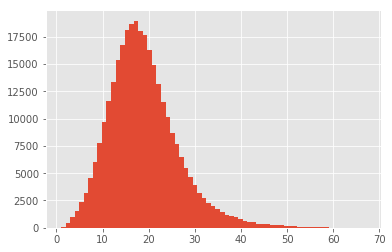

In [6]:
plt.hist((df.title.str.split().apply(len)), bins=67)

In [7]:
maxlen = 40 
title_tf = sequence.pad_sequences(title_tf, maxlen=maxlen)

print(title_tf[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    99 12138]


In [8]:
embedding_vectors = utilities.get_embeddings(embeddings_path)
        
print(embedding_vectors['you'])

[  1.96400000e-01   6.71530000e-01   6.29760000e-03   2.53590000e-01
  -4.20970000e-01   3.84900000e-01   1.03780000e+00  -1.85360000e-01
  -5.42440000e-02  -1.08560000e-01   1.21460000e-01   4.76920000e-02
  -9.32280000e-01  -2.71920000e-01  -3.50600000e-01   1.10690000e-01
  -5.50990000e-02  -7.96580000e-02   1.17670000e-02   1.43950000e-01
  -2.59170000e-02  -1.82530000e-01   2.56910000e-02   1.96190000e-01
   1.03340000e-01   1.07310000e+00   4.19920000e-01   1.70830000e-01
   9.15960000e-01  -4.33980000e-01   1.64640000e-01   1.27150000e-02
   9.54770000e-02   1.44900000e-01  -2.96520000e-01  -1.06420000e-01
   9.83890000e-02   1.79370000e-01   2.32890000e-01  -2.22090000e-01
   8.77700000e-02  -1.80050000e-01   3.86780000e-01  -3.20590000e-02
   1.20200000e-01  -4.17410000e-01   2.68270000e-01  -1.97690000e-01
   2.19760000e-02  -2.35850000e-01   1.47890000e-01   1.01730000e-01
  -1.03800000e-01  -3.19540000e-01   6.33080000e-01  -5.11420000e-02
  -5.32090000e-02   2.93780000e-01

In [9]:
weights_matrix = np.zeros((max_features + 1, 200))

for word, i in word_tokenizer.word_index.items():

    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None and i <= max_features:
        weights_matrix[i] = embedding_vector

# index 0 vector should be all zeroes, index 1 vector should be the same one as above
print(weights_matrix[0:2,:])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

In [10]:
print(f'Day of year minimum = {min(dayofyear)}')
dayofyear_tf = dayofyear - min(dayofyear)

Day of year minimum = 1


In [11]:
from keras.models import Input, Model
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, concatenate, Activation
from keras.layers.core import Masking, Dropout, Reshape
from keras.layers.normalization import BatchNormalization

batch_size = 32
embedding_dims = 200
epochs = 20

In [12]:
title_input = Input(shape=(maxlen,), name='title_input')
title_embedding = Embedding(max_features + 1, embedding_dims, weights=[weights_matrix])(title_input)
title_pooling = GlobalAveragePooling1D()(title_embedding)

In [13]:
aux_output = Dense(1, activation='sigmoid', name='aux_out')(title_pooling)

In [14]:
meta_embedding_dims = 64

minute_input = Input(shape=(1,), name='minute_input')
minute_embedding = Embedding(60, meta_embedding_dims)(minute_input)
minute_reshape = Reshape((meta_embedding_dims,))(minute_embedding)

hour_input = Input(shape=(1,), name='hour_input')
hour_embedding = Embedding(24, meta_embedding_dims)(hour_input)
hour_reshape = Reshape((meta_embedding_dims,))(hour_embedding)

dayofweek_input = Input(shape=(1,), name='dayofweek_input')
dayofweek_embedding = Embedding(7, meta_embedding_dims)(dayofweek_input)
dayofweek_reshape = Reshape((meta_embedding_dims,))(dayofweek_embedding)

dayofyear_input = Input(shape=(1,), name='dayofyear_input')
dayofyear_embedding = Embedding(366, meta_embedding_dims)(dayofyear_input)
dayofyear_reshape = Reshape((meta_embedding_dims,))(dayofyear_embedding)

edit_delta_minute_input = Input(shape=(1,), name='edit_delta_minute_input')
edit_delta_minute_embedding = Embedding(60, meta_embedding_dims)(edit_delta_minute_input)
edit_delta_minute_reshape = Reshape((meta_embedding_dims,))(edit_delta_minute_embedding)

edit_delta_hour_input = Input(shape=(1,), name='edit_delta_hour_input')
edit_delta_hour_embedding = Embedding(24, meta_embedding_dims)(edit_delta_hour_input)
edit_delta_hour_reshape = Reshape((meta_embedding_dims,))(edit_delta_hour_embedding)

edit_delta_day_input = Input(shape=(1,), name='edit_delta_day_input')
edit_delta_day_embedding = Embedding(7, meta_embedding_dims)(edit_delta_day_input)
edit_delta_day_reshape = Reshape((meta_embedding_dims,))(edit_delta_day_embedding)

In [24]:
merged = concatenate([title_pooling, hour_reshape, dayofweek_reshape, minute_reshape, dayofyear_reshape, edit_delta_minute_reshape, edit_delta_hour_reshape, edit_delta_day_reshape])
merged = concatenate([title_pooling, hour_reshape, dayofweek_reshape, minute_reshape, dayofyear_reshape, edit_delta_day_reshape])

hidden_1 = Dense(256, activation='relu')(merged)
hidden_1 = BatchNormalization()(hidden_1)

main_output = Dense(1, activation='sigmoid', name='main_out')(hidden_1)

In [26]:
model = Model(inputs=[title_input,
                      hour_input,
                      dayofweek_input,
                      minute_input,
                      dayofyear_input,
                      edit_delta_day_input],
              outputs=[main_output, aux_output])
# model = Model(inputs=[title_input,
#                       hour_input,
#                       dayofweek_input,
#                       minute_input,
#                       dayofyear_input,
#                       edit_delta_minute_input,
#                       edit_delta_hour_input,
#                       edit_delta_day_input], 
#               outputs=[main_output, aux_output])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              loss_weights=[1, 0.2])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 40)           0                                            
__________________________________________________________________________________________________
hour_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
dayofweek_input (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
minute_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
dayofyear_

In [27]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

!['blah'](model.png)

Make sure to add graphviz to your path so it works with python. [Source](https://stackoverflow.com/questions/36886711/keras-runtimeerror-failed-to-import-pydot-after-installing-graphviz-and-pyd)

In [18]:
seed(42)
split = 0.2

# returns randomized indices with no repeats
idx = sample(range(title_tf.shape[0]), title_tf.shape[0])

score = score[idx]
num_comments = num_comments[idx]

title_tf = title_tf[idx, :]
hour = hour[idx]
dayofweek = dayofweek[idx]
minute = minute[idx]
dayofyear_tf = dayofyear_tf[idx]
edited_delta_min = edited_delta_min[idx]
edited_delta_hour = edited_delta_hour[idx]
edited_delta_day = edited_delta_day[idx]

In [19]:
score = score > score.mean()

In [22]:
from keras.callbacks import CSVLogger, TensorBoard
import tensorflow as tf

csv_logger = CSVLogger('training.csv')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [29]:
# model.fit([title_tf, hour, dayofweek, minute, dayofyear_tf, edited_delta_min, edited_delta_hour, edited_delta_day], [score, score],
model.fit([title_tf, hour, dayofweek, minute, dayofyear_tf, edited_delta_day], [score, score],
          batch_size=None,
          epochs=epochs,
          validation_split=split, callbacks=[tbCallBack])

Train on 247985 samples, validate on 61997 samples
Epoch 1/20


InvalidArgumentError: indices[1,0] = -1 is not in [0, 7)
	 [[Node: embedding_8/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_8/embeddings/read, embedding_8/Cast)]]

Caused by op 'embedding_8/Gather', defined at:
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-9cb6eeead343>", line 28, in <module>
    edit_delta_day_embedding = Embedding(7, meta_embedding_dims)(edit_delta_day_input)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\keras\engine\topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\keras\layers\embeddings.py", line 138, in call
    out = K.gather(self.embeddings, inputs)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\keras\backend\tensorflow_backend.py", line 1208, in gather
    return tf.gather(reference, indices)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1207, in gather
    validate_indices=validate_indices, name=name)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\DT-Laptop\Anaconda3\envs\new_ds\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[1,0] = -1 is not in [0, 7)
	 [[Node: embedding_8/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_8/embeddings/read, embedding_8/Cast)]]
